In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn import metrics
# import statsmodels.api as sm
rcParams['figure.figsize'] = 11.7,8.27

### Summary Statistics 

In [8]:
data = pd.read_csv("data.csv")
data = data.drop('id', 1)
data['diagnosis'] = data['diagnosis'].replace('M', 1.0).replace('B', 0.0)
data = data.drop('Unnamed: 32', 1)
headers = list(data)[1:]
print(data.describe())

        diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720       

Note: logistic regression does not assume that residuals are normally distributed or homoscedascticity. 

### Get Training and Test Data

In [9]:
train, test = train_test_split(data, test_size = 0.2)

y_train = train['diagnosis']
x_train = train[headers]

print(x_train.shape, y_train.shape)

y_test = test['diagnosis']
x_test = test[headers]

print(x_test.shape, y_test.shape)

#for cross-validation 
x = data[headers]
y = data['diagnosis']

(455, 30) (455,)
(114, 30) (114,)


### Exploring Correlation

In [10]:
corr = data.corr()
print(corr['diagnosis'].sort_values())

smoothness_se             -0.067016
fractal_dimension_mean    -0.012838
texture_se                -0.008303
symmetry_se               -0.006522
fractal_dimension_se       0.077972
concavity_se               0.253730
compactness_se             0.292999
fractal_dimension_worst    0.323872
symmetry_mean              0.330499
smoothness_mean            0.358560
concave points_se          0.408042
texture_mean               0.415185
symmetry_worst             0.416294
smoothness_worst           0.421465
texture_worst              0.456903
area_se                    0.548236
perimeter_se               0.556141
radius_se                  0.567134
compactness_worst          0.590998
compactness_mean           0.596534
concavity_worst            0.659610
concavity_mean             0.696360
area_mean                  0.708984
radius_mean                0.730029
area_worst                 0.733825
perimeter_mean             0.742636
radius_worst               0.776454
concave points_mean        0

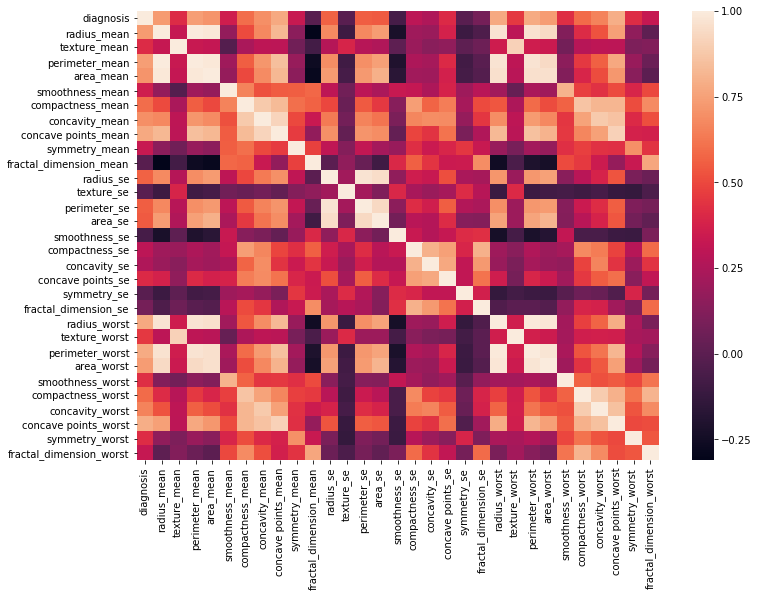

In [5]:
fig = sns.heatmap(corr, 
        #annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [6]:
filtered_corr = corr.gt(.75, 0)
filtered_corr = filtered_corr.apply(lambda x: ', '.join(x.index[x]), axis = 1)

### VIF

In [7]:
# endog = y_train
# exog = sm.add_constant(x_train)
# logit = sm.Logit(endog, exog)
# result = logit.fit()

### Logistic Regression with all Parameters

In [8]:
model = LogisticRegression(C = 1e50)
model.fit(x_train, y_train)
print(model.coef_[0])

[-4.72110256 -0.27654057  0.32913197  0.01944185  0.50623187  0.97497404
  1.70877093  1.13354383  0.69126188  0.06719009  0.28543335 -3.08861434
 -1.0630208   0.24819839  0.067982   -0.13068494 -0.01140234  0.1486149
  0.18250557 -0.02612351 -0.2963813   0.56431523  0.05316636  0.01220591
  1.02450917  2.28474084  3.63197206  2.27536785  2.18356046  0.23721918]


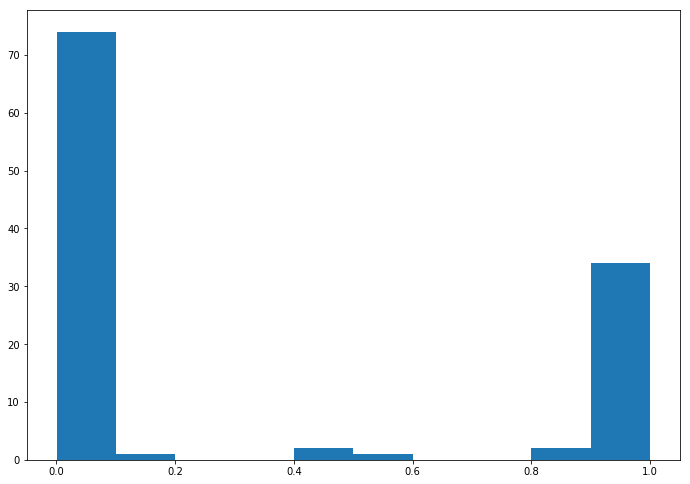

In [9]:
#need to add more bins to plot
predicted = model.predict(x_test)
probs = model.predict_proba(x_test)
probs = np.delete(probs, np.s_[0:1], axis =1).flatten()
plt.hist(probs)
plt.show()

In [10]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs))
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

0.973684210526
0.998529411765
[[77  3]
 [ 0 34]]
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98        80
        1.0       0.92      1.00      0.96        34

avg / total       0.98      0.97      0.97       114



In [11]:
acc = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = 'recall', cv = 10)
print('Recall:' + str(recall.mean()))
prec = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = 'precision', cv = 10)
print('Precision:' + str(prec.mean()))

Accuracy:0.954378402904
Recall:0.929653679654
Precision:0.949028202918


### Recursive Feature Elimination

In [69]:
rfe = RFE(model, 4) #keep 4 parameters
fit = rfe.fit(x_train, y_train)
predictors = [headers[i] for i,p in enumerate(fit.support_) if p]
print(predictors)

['smoothness_mean', 'concave points_mean', 'smoothness_se', 'smoothness_worst']


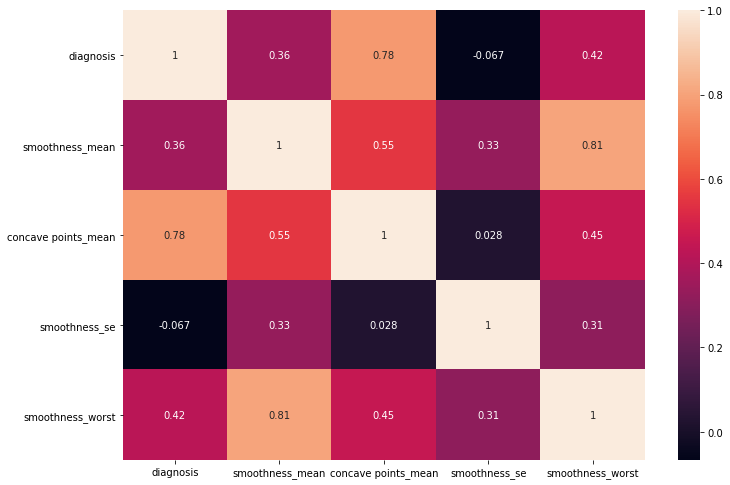

In [64]:
to_drop = list(set(headers) - set(predictors))
rfe_x = x.drop(to_drop, 1)
rfe_x_train = x_train.drop(to_drop, 1)
rfe_x_test = x_test.drop(to_drop, 1)
rfe_data = data.drop(to_drop, 1)

rfe_corr = rfe_data.corr()
fig = sns.heatmap(rfe_corr, 
        annot = True,
        xticklabels=rfe_corr.columns,
        yticklabels=rfe_corr.columns)
plt.show()

In [65]:
rfe = LogisticRegression(C=1e50)
rfe.fit(rfe_x_train, y_train)
rfe_coefficients = rfe.coef_[0]
print(rfe_coefficients)

[-181.91584834  136.55991989 -170.03920643   90.12802806]


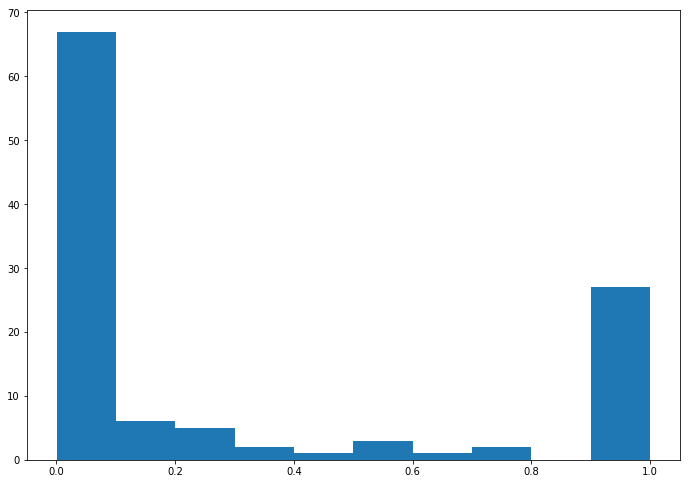

In [66]:
rfe_predicted = rfe.predict(rfe_x_test)
rfe_probs = rfe.predict_proba(rfe_x_test)
rfe_probs = np.delete(rfe_probs, np.s_[0:1], axis =1).flatten()
plt.hist(rfe_probs)
plt.show()

In [67]:
print(metrics.accuracy_score(y_test, rfe_predicted))
print(metrics.roc_auc_score(y_test, rfe_probs))
print(metrics.confusion_matrix(y_test, rfe_predicted))
print(metrics.classification_report(y_test, rfe_predicted))

0.973684210526
0.990441176471
[[79  1]
 [ 2 32]]
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98        80
        1.0       0.97      0.94      0.96        34

avg / total       0.97      0.97      0.97       114



In [68]:
acc = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = 'recall', cv = 10)
print('Recall:' + str(recall.mean()))
prec = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = 'precision', cv = 10)
print('Precision:' + str(prec.mean()))

Accuracy:0.943974159537
Recall:0.89632034632
Precision:0.954696969697


### Lasso Regression

In [18]:
lasso = LogisticRegression(penalty = 'l1', solver = "liblinear", C=1)
lasso.fit(x_train, y_train)
lasso_coefficients = lasso.coef_[0]
predictors = list([(headers[i], c) for i,c in enumerate(lasso_coefficients) if c != 0])
print(predictors)
print(len(predictors))

[('radius_mean', -3.1455982330258738), ('texture_mean', -0.1288648846593046), ('perimeter_mean', 0.093382852686633752), ('area_mean', 0.012365624771952102), ('texture_se', -1.507517736615213), ('area_se', 0.11596013449307507), ('radius_worst', -0.2927195704438737), ('texture_worst', 0.35296913784397771), ('perimeter_worst', 0.086235135031102805), ('area_worst', 0.017074459524610702), ('concavity_worst', 3.7994912301665136)]
11


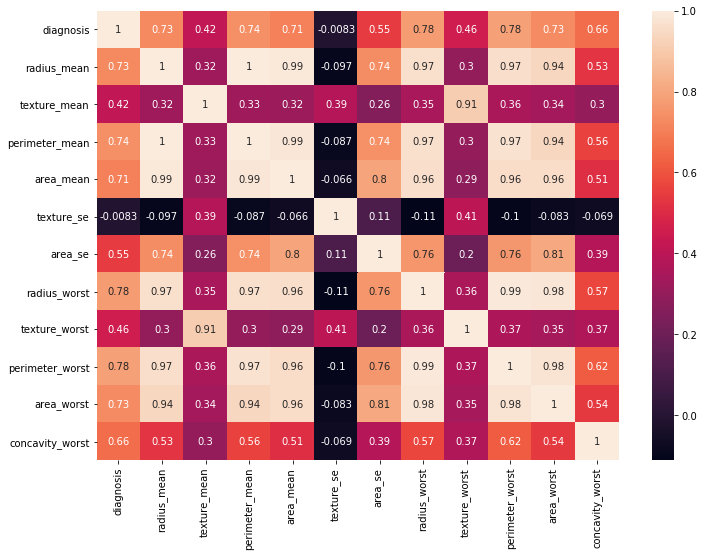

In [19]:
to_drop = list(set(headers) - set([p[0] for p in predictors]))
lasso_data = data.drop(to_drop, 1)
lasso_corr = lasso_data.corr()
fig = sns.heatmap(lasso_corr, 
        annot = True,
        xticklabels=lasso_corr.columns,
        yticklabels=lasso_corr.columns)
plt.show()

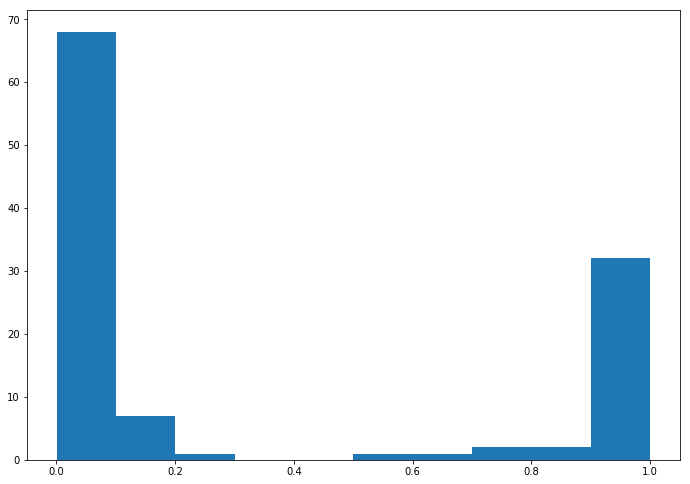

In [20]:
lasso_predicted = lasso.predict(x_test)
lasso_probs = lasso.predict_proba(x_test)
lasso_probs = np.delete(lasso_probs, np.s_[0:1], axis =1).flatten()
plt.hist(lasso_probs)
plt.show()

In [21]:
print(metrics.accuracy_score(y_test, lasso_predicted))
print(metrics.roc_auc_score(y_test, lasso_probs))
print(metrics.confusion_matrix(y_test, lasso_predicted))
print(metrics.classification_report(y_test, lasso_predicted))

0.964912280702
0.998897058824
[[76  4]
 [ 0 34]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97        80
        1.0       0.89      1.00      0.94        34

avg / total       0.97      0.96      0.97       114



In [22]:
acc = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = 'recall', cv = 10)
print('Recall:' + str(recall.mean()))
prec = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = 'precision', cv = 10)
print('Precision:' + str(prec.mean()))

Accuracy:0.945697217181
Recall:0.915584415584
Precision:0.952372168894


### Decision Tree for Variable Selection

In [16]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100)
decision_tree = clf_gini.fit(x_train, y_train)
dtfeatures = list(zip(headers, decision_tree.feature_importances_))



In [20]:
sorted_features_dt = sorted(dtfeatures, key = lambda x:x[1], reverse = True)
print(sorted_features_dt)

[('radius_worst', 0.6885684936532395), ('concave points_worst', 0.14949688961425145), ('texture_worst', 0.10230010561460316), ('smoothness_mean', 0.015655664585191794), ('fractal_dimension_se', 0.014459745762711864), ('smoothness_worst', 0.009424554302528343), ('fractal_dimension_mean', 0.00913247100802855), ('compactness_worst', 0.006426553672316384), ('radius_se', 0.003036366088998824), ('smoothness_se', 0.0014991556981302286), ('radius_mean', 0.0), ('texture_mean', 0.0), ('perimeter_mean', 0.0), ('area_mean', 0.0), ('compactness_mean', 0.0), ('concavity_mean', 0.0), ('concave points_mean', 0.0), ('symmetry_mean', 0.0), ('texture_se', 0.0), ('perimeter_se', 0.0), ('area_se', 0.0), ('compactness_se', 0.0), ('concavity_se', 0.0), ('concave points_se', 0.0), ('symmetry_se', 0.0), ('perimeter_worst', 0.0), ('area_worst', 0.0), ('concavity_worst', 0.0), ('symmetry_worst', 0.0), ('fractal_dimension_worst', 0.0)]


In [21]:
select = SelectFromModel(decision_tree, threshold = 0.1)
select.fit(x_train, y_train)
predictorsdt = []
for feature_list_index in select.get_support(indices=True):
    predictorsdt.append(headers[feature_list_index])
print(predictorsdt)
print(len(predictorsdt))

['radius_worst', 'texture_worst', 'concave points_worst']
3


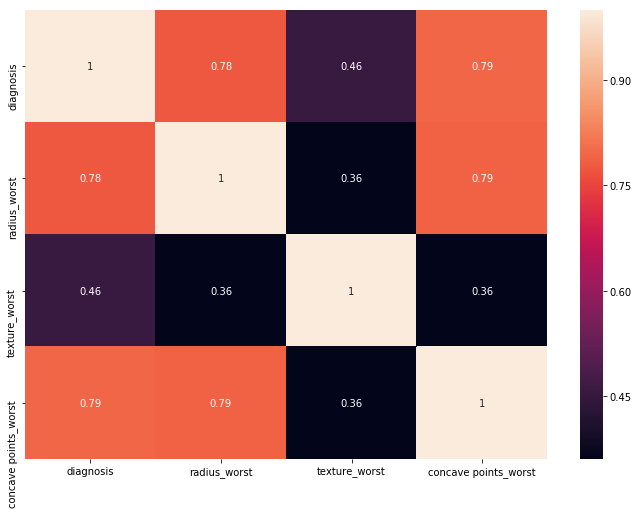

In [23]:
to_drop_dt = list(set(headers) - set(predictorsdt))
dt_data = data.drop(to_drop_dt, 1)
dt_corr = dt_data.corr()
figdt = sns.heatmap(dt_corr, 
        annot = True,
        xticklabels=dt_corr.columns,
        yticklabels=dt_corr.columns)
plt.show()

In [25]:
x_important_train_dt= select.transform(x_train)
x_important_test_dt = select.transform(x_test)
x_important_dt = select.transform(x)
dt = LogisticRegression(C=1e50)
dt.fit(x_important_train_dt, y_train)
print(dt.coef_)

[[ 1.22773575  0.27490768 56.88010046]]


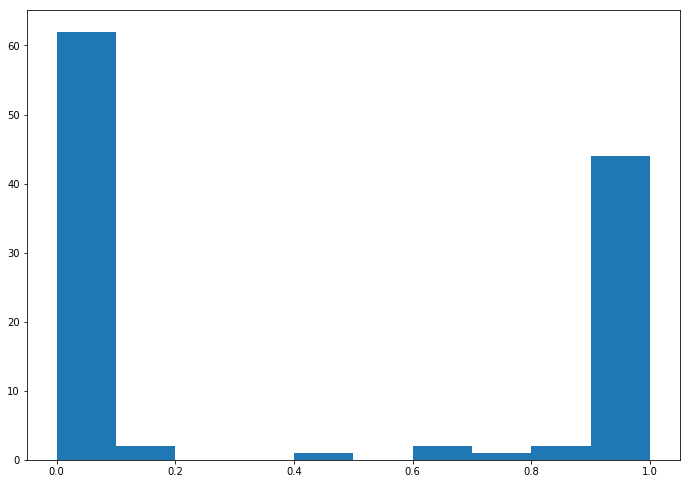

In [26]:
dt_predicted = dt.predict(x_important_test_dt)
dt_probs = dt.predict_proba(x_important_test_dt)
dt_probs = np.delete(dt_probs, np.s_[0:1], axis =1).flatten()
plt.hist(dt_probs)
plt.show()

In [27]:
print(metrics.accuracy_score(y_test, dt_predicted))
print(metrics.roc_auc_score(y_test, dt_probs))
print(metrics.confusion_matrix(y_test, dt_predicted))
print(metrics.classification_report(y_test, dt_predicted))

0.9736842105263158
0.9910049627791562
[[62  0]
 [ 3 49]]
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.98        62
        1.0       1.00      0.94      0.97        52

avg / total       0.97      0.97      0.97       114



In [29]:
acc_dt = cross_val_score(LogisticRegression(C = 1e50), x_important_dt, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc_dt.mean()))
recall_dt = cross_val_score(LogisticRegression(C = 1e50), x_important_dt, y, scoring = 'recall', cv = 10)
print('Recall:' + str(recall_dt.mean()))
prec_dt = cross_val_score(LogisticRegression(C = 1e50), x_important_dt, y, scoring = 'precision', cv = 10)
print('Precision:' + str(prec_dt.mean()))

Accuracy:0.9649068792671333
Recall:0.9484848484848485
Precision:0.9581441746659138


### Random Forest for Variable Selection

In [17]:
random_forest = RandomForestClassifier(n_estimators = 10000)
random_forest.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
features = list(zip(headers, random_forest.feature_importances_))
sorted_features = sorted(features, key = lambda x:x[1], reverse = True)
print(sorted_features)

[('concave points_worst', 0.13044004871707188), ('perimeter_worst', 0.12849492651911501), ('area_worst', 0.11367117677496133), ('radius_worst', 0.10526658184300736), ('concave points_mean', 0.091130982853052031), ('concavity_mean', 0.053305684580387216), ('perimeter_mean', 0.042916102117080225), ('area_mean', 0.041962290377948436), ('area_se', 0.039254953647998317), ('concavity_worst', 0.036355514483520625), ('radius_mean', 0.035129332349608328), ('texture_worst', 0.021505657507003097), ('texture_mean', 0.018739404883420737), ('compactness_worst', 0.017286997994232656), ('radius_se', 0.014890637146666259), ('perimeter_se', 0.014498999959363143), ('smoothness_worst', 0.013801735425701744), ('compactness_mean', 0.011874601191448441), ('symmetry_worst', 0.010044689884687969), ('fractal_dimension_worst', 0.0072668509382944266), ('concavity_se', 0.0068866478994815752), ('smoothness_mean', 0.0064093620308267969), ('smoothness_se', 0.0055295470557085299), ('concave points_se', 0.0054494952384

In [31]:
#identify features that have an importance of more than 0.10
sfm = SelectFromModel(random_forest, threshold = 0.1)
sfm.fit(x_train, y_train)
predictors = []
for feature_list_index in sfm.get_support(indices=True):
    predictors.append(headers[feature_list_index])
print(predictors)
print(len(predictors))

['radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']
4


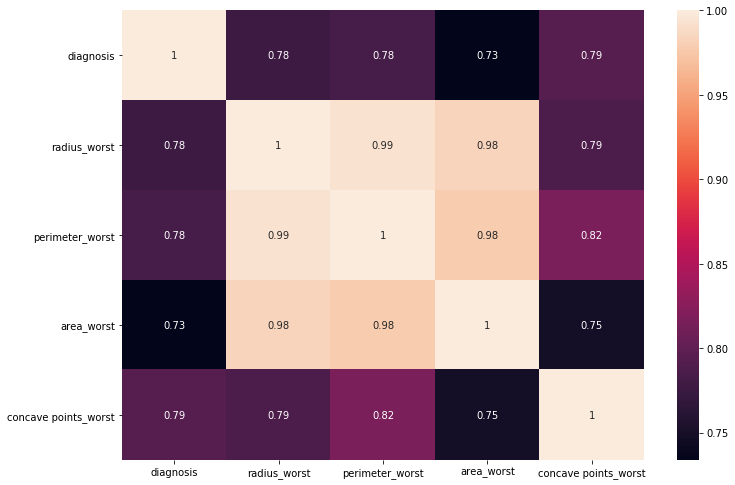

In [32]:
to_drop = list(set(headers) - set(predictors))
rf_data = data.drop(to_drop, 1)
rf_corr = rf_data.corr()
fig = sns.heatmap(rf_corr, 
        annot = True,
        xticklabels=rf_corr.columns,
        yticklabels=rf_corr.columns)
plt.show()

In [33]:
x_important_train = sfm.transform(x_train)
x_important_test = sfm.transform(x_test)
x_important = sfm.transform(x)
rf = LogisticRegression(C=1e50)
rf.fit(x_important_train, y_train)
print(rf.coef_)

[[ -8.31715094e-01  -3.82316951e-02   2.05850382e-02   4.10788234e+01]]


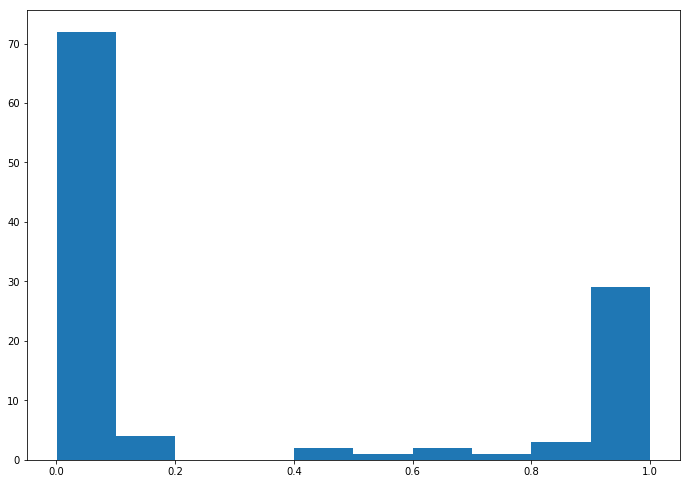

In [34]:
rf_predicted = rf.predict(x_important_test)
rf_probs = rf.predict_proba(x_important_test)
rf_probs = np.delete(rf_probs, np.s_[0:1], axis =1).flatten()
plt.hist(rf_probs)
plt.show()

In [35]:
print(metrics.accuracy_score(y_test, rf_predicted))
print(metrics.roc_auc_score(y_test, rf_probs))
print(metrics.confusion_matrix(y_test, rf_predicted))
print(metrics.classification_report(y_test, rf_predicted))

0.982456140351
0.997794117647
[[78  2]
 [ 0 34]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99        80
        1.0       0.94      1.00      0.97        34

avg / total       0.98      0.98      0.98       114



Note: With only one feature (perimeter worst), we are 88.6% acccurate

In [36]:
acc = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = 'recall', cv = 10)
print('Recall:' + str(recall.mean()))
prec = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = 'precision', cv = 10)
print('Precision:' + str(prec.mean()))

Accuracy:0.950899879008
Recall:0.915584415584
Precision:0.95318909923
